## DCGAN using MNIST

Deep Convolutional Generative Adversarial Network [DCGAN] is a Unsupervised Learning Technique that learns a hierarchy of representations from object parts to scenes in both the Generator and Discriminator. The Generative Adversarial Networks [GAN] was introduced by Ian Goodfellow, an architecture whose aim was to learn from the errors or the loss of the output that the generator generated and tune it's parameters such that it is able to generate the output that fools a discriminator. A discriminator is nothing but a classifier that trains on the data and learns to classify the data generated by the discriminator as fake or real.

In this tutorial, we'll be implementing the DCGAN Architecture, slightly modified to fit for the MNIST Dataset and see how the DCGAN is able to generate MNIST images from noise input by learning the representations and decreasing the generator loss.

So, let's get started.

## Step-1: Import Dependencies

In [1]:
# Import Dependencies
import numpy as np

# Dataset
from keras.datasets.mnist import load_data
from keras.models import Sequential

# Common Layers
from keras.layers import Dense, Activation, BatchNormalization, Reshape, Flatten 
from keras.optimizers import Adam

# Layers specific to Generator
from keras.layers import Conv2DTranspose

# Layers specific to Discriminator
from keras.layers import Conv2D, LeakyReLU 

# Use this to pass an element-wise TensorFlow/Theano/CNTK function as an activation
import keras.backend as k

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


For this code, I'll be starting with the MNIST Dataset and then using the same architecture on other datasets like CIFAR, Faces Dataset etc.

The MNIST dataset will be laoded using the Keras "load_data" functionality. When we load the data using this, it is loaded into training and test set as a tuple of each. i.e. a tuple of training features and labels and a tuple of test features and labels.

Then we will analyze the dataset for its number of features and labels and visualize the dataset at the end.

## Step-2: Load and Visualize Dataset

In [2]:
# Load Dataset
(X_train, y_train), (X_test, y_test) = load_data()

In [3]:
# Get Data Analysis
print('Training Data: \n')
print('Num. Features: ',len(X_train)), print('Num. Labels: ',len(y_train))
print('Shape of Features: ',X_train.shape), print('Shape of Labels: ',y_train.shape)
print('\n\n')

print('Test Data: \n')
print('Num. Features: ',len(X_test)), print('Num. Labels: ',len(y_test))
print('Shape of Features: ',X_test.shape), print('Shape of Labels: ', y_test.shape)

Training Data: 

Num. Features:  60000
Num. Labels:  60000
Shape of Features:  (60000, 28, 28)
Shape of Labels:  (60000,)



Test Data: 

Num. Features:  10000
Num. Labels:  10000
Shape of Features:  (10000, 28, 28)
Shape of Labels:  (10000,)


(None, None)

So, as we can see, there are 60,000 training features and labels and 10,000 test features and labels. The shape of the total dataset is :

Training: (60000, 28,28)

Test: (10000, 28, 28)

Let's take a look at the individual image shape.

In [4]:
# Shape of One Image
rand_idx = np.random.randint(0, len(X_train), 1)
print('Shape of one Image: ', X_train[rand_idx].shape)

Shape of one Image:  (1, 28, 28)


Each image in the MNIST dataset is of the shape (28,28) i.e. a total of 784 pixel values.

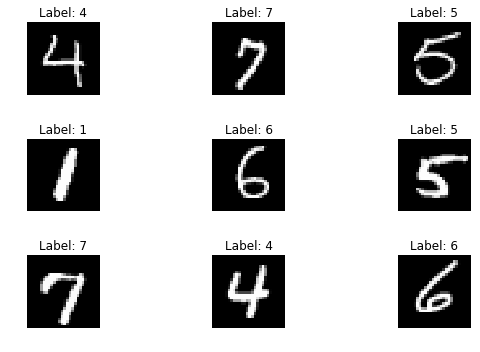

In [5]:
# Visualize Images
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,5))
for i in range(0,3):
    for j in range(0,3):
        idx = np.random.randint(0, len(X_train), 1)
        idx = idx[0]
        ax[i,j].imshow(X_train[idx], cmap='gray')
        ax[i,j].set_axis_off()
        ax[i,j].title.set_text('Label: {}'.format(y_train[idx]))
        plt.tight_layout()

## Step-3: Data Preprocessing

According to the paper, the input images were scaled to the range of [-1,1]. Using this ensures that each input parameter i.e. the pixels in the case of images have a similar data distribution. This helps as it speeds up the convergence while training the model. This also helps to avoid vanishing gradient problem while backpropagation. 

So, next, we'll write a function that does just that.

In [6]:
# Taking a random image and looking at its pixel values
idx = np.random.randint(0, len(X_train), 1)
print('Image Index No.: ', idx)
print('\nImage Pixel Values [Before Normalization]: \n\n',X_train[idx])
print('\n\n Shape of Image: ',X_train[idx].shape)

Image Index No.:  [33596]

Image Pixel Values [Before Normalization]: 

 [[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  29 255 141   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0 114 170 226 255 255   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0 170 255 255 255 255 255  29
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0  29 170 141  86 255 255   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255   0
     0   0   0   0 

In the above lines, we take a random image and see that it has the values that lie in the range (0,255). So, let's write a function to take in these images and normalize them to the range of (-1,1). Also, the paper tells that the dense layer i.e. the layer before the first convolution layer for the generator is a 4-D tensor. So, we'll reshape all of the training data here as well and add a 4th dimension up front.

Also, we'll also write a de-normalizing function to reshape the generated images to the shape (28,28) and the pixel values in the range (0,255) before plotting the final generated images.

In [7]:
# Function to apply Normalization similar to tanh activation function range i.e. [-1,1]
def normalize_images(img):
    img = img.reshape(-1,28,28,1)
    img = np.float32(img)
    img = (img / 255 - 0.5) * 2
    img = np.clip(img, -1, 1)
    return img

In [8]:
# Function to DeNormalize the Images once we are done Training the DCGAN Model
def denormalize_images(img):
    img = (img / 2 + 1) * 255
    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = img.reshape(28, 28)
    return img

Now that we are done with the normalizing and denormalizing functions, let's normalize the training and test features and have a look at the same image after normalization and the overall shape of the train and test features.

In [9]:
# Normalize the Training and Test Features
X_train = normalize_images(X_train)
X_test = normalize_images(X_test)

In [ ]:
# Test the Normalization Function
print('Image Index No.: ', idx)
print('\nImage Pixel Values [After Normalization]: \n\n',X_train[idx])

So, as we can see, using normalization our image pixel values have been changed from the scale of (0,255) to the scale of (-1,1).

In [10]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Step-4: DCGAN Generator Architecture

The paper describes the DCGAN Generator Architecture as shown in the following image:

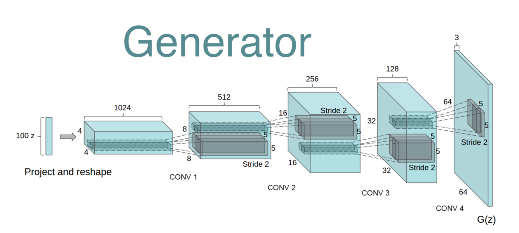

In [11]:
# Display Generator Architecture
from IPython.display import Image
Image(filename='./Images/generator.png', width=900) 

The Generator for DCGAN has the following components:

**1. Input Layer [Dense]:**

This layer is where we provide the noise Input using which, over time and training the Generator is able to convert into an image at the output.

This layer is a Fully Connected or Dense layer that takes the pixels of the image. For this tutorial, we'll be using the input units with a dimension of 7*7*128. As per the paper, the input shape for the dense layer is 100z, so, we'l be using the input shape as 100.

**2. Reshape:**

Before giving the data into the Transposed Convolution function, we need to reshape the input data so that we can convert the array of values to a matrix and apply convolution operations on it.

Input Shape: **[7*7*128]**

After Reshaping, Input to Transpose Convolution Function: **[7,7,128]**

**3. 2-D Transposed Convolution [Conv2DTranspose]:**

As per the architecture of DCGAN mentioned in the paper, the Generator performs a series of Transposed Convolutions after getting the data from the dense layer and at the final layer we get a 64x64 image from these high level representations.
Since, the first Transposed Convolution layer has a shape of 7 x 7 x 128 with a filter of 5 x 5 and stride of 2, the next transposed convolution layer will have the shape of 14 x 14 x 64, and then finally 28 x 28 x 1 i.e. the image.

**4. Activation Functions [ReLU, Tanh]:**

As per the paper, the Transposed Convolution layers use the ReLU activation function whereas we use a tanh activation function for the final layer. Using the bounded activation function allows the model to learn more quickly to saturate and cover the color space of the training distribution.

** -------------------------------------------------------------------------------------------------------------------------- **

**NOTE:** In case you are thinking that from where all these shapes for the convolutions appeared from, let's have a look.
1. We know that, each MNIST image has a shape of  28 x 28 x 1 where 1 is the color channel and since the image is black and white, so it's 1.
2. Look at the generator from the image side. You have an image with the shape 28x28x1 as input.
3. Then, for filter of 5x5, stride of 2 and same padding, we can find out the shape of the next output as follows:

### output shape = (W + 2*P - F) + 1 / S

where, 

**W:** Width of Input Image

**P:** Padding

**F:** Size of Filter

**S:** Stride

So, using the values that we defined above, we get the output as:

** Shape of output after 1st convolution:** (28 + 2*2 - 5) + 1 / 2  => 14 or  14 x 14 x number of filters

So, if the number of filters = 64, the shape of output becomes:  14 x 14 x 64

Similarly, for the next layer with the same configuration, the shape will be: 7 x 7 x 128.

Well, you might think that why I said convolutions and not Transposed Convolutions, that is because we went from image to last filter. This is what is the architecture for Discriminator. If we just use this in the opposite order, it becomes the size for the Generator. You will see more when we print out the summary of the Generator and the Discriminator.

** -------------------------------------------------------------------------------------------------------------------------- **

So, let's define the Generator Function.

In [12]:
# Generator
def generator(inputSize):
    generator_model = Sequential()
    # Input Dense Layer
    generator_model.add(Dense(7*7*128, input_shape=(inputSize,)))
    # Reshape the Input, apply Batch Normalization and Leaky ReLU Activation.
    generator_model.add(Reshape(target_shape=(7,7,128)))
    generator_model.add(BatchNormalization())
    generator_model.add(Activation('relu'))
    
    # First Transpose Convolution Layer
    generator_model.add(Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same'))
    generator_model.add(BatchNormalization())
    generator_model.add(Activation('relu'))
        
    # Since, we are using MNIST Data which has only 1 channel, so filter for Generated Image = 1
    generator_model.add(Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same'))
    generator_model.add(Activation('tanh'))
    
    generator_model.summary()
    
    return generator_model

## Step-5: DCGAN Discriminator Architecture

The paper describes the DCGAN Discriminator Architecture as shown in the following image:

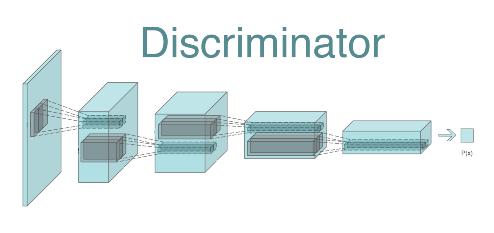

In [13]:
# Display Discriminator Architecture
from IPython.display import Image
Image(filename='./Images/discriminator.png', width=900) 

The discriminator for DCGAN has the following components:

**1. 2-D Convolution [Conv2D]:**

Since, the aim of the discriminator is to classify images between real and fake, it takes in the complete image generated by the generator and try to tell that whether it is a true or a fake image. Hence, CNN comes into play as they are the state of the art networks for image classification. So, we use Convolution filters for the first 3 layers as opposed to Transpose Convolution in the Generator.


**2. Activation Functions [LeakyReLU]:**

As per the paper, the Convolution layers use the LeakyReLU activation function throughout the discriminator layers. Using the bounded activation function allows the model to learn more quickly to saturate and cover the color space of the training distribution.

**NOTE:** The shapes for the Discriminator have been defined in the Generator text.

In [14]:
# Discriminator
def discriminator(leakSlope):
    discriminator_model = Sequential()
    
    # Input and First Conv2D Layer
    discriminator_model.add(Conv2D(filters=64, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)))
    discriminator_model.add(LeakyReLU(alpha=leakSlope))
    
    # Second Conv2D Layer
    discriminator_model.add(Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU(alpha=leakSlope))
    
    # Third Layer
    discriminator_model.add(Flatten())
    discriminator_model.add(Dense(784))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU(alpha=leakSlope))
    
    # Output Layer
    discriminator_model.add(Dense(1))
    discriminator_model.add(Activation('sigmoid'))
    
    discriminator_model.summary()
    
    return discriminator_model

Now that we have defined the Generator and the Discriminator, we just need to combine these two in a single place to form a DCGAN architecture. So, let's do that.

## Step-6: DCGAN Architecture

The paper defines the DCGAN Architecture as follows:

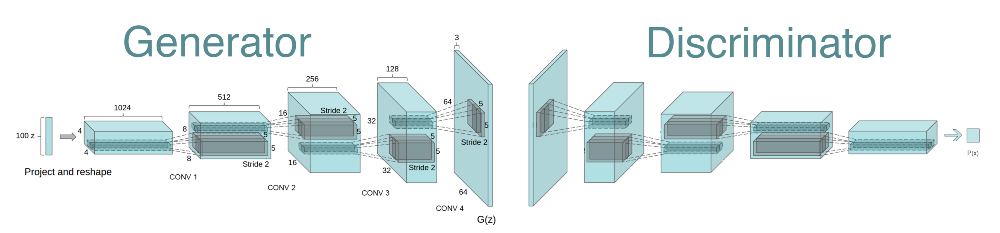

In [1]:
# Display Discriminator Architecture
from IPython.display import Image
Image(filename='./Images/complete_dcgan.png', width=900) 

In [15]:
# Define DCGAN Architecture
def DCGAN(sample_size, generator_lr, generator_momentum, discriminator_lr, discriminator_momentum, leakyAlpha, show_summary=False):
    
    # Clear Session
    k.clear_session()
    
    # Generator
    gen = generator(inputSize=100)
    
    # Discrimintor
    dis = discriminator(leakSlope=0.2)
    dis.compile(loss='binary_crossentropy', optimizer=Adam(lr=discriminator_lr, beta_1=discriminator_momentum))
    
    dis.trainable = False
    
    dcgan = Sequential([gen, dis])
    dcgan.compile(loss='binary_crossentropy', optimizer=Adam(lr=generator_lr, beta_1=generator_momentum))
    
    if show_summary == True:
        print("\n Generator Model Summary: \n")
        gen.summary()
        
        print("\n\n Discriminator Model Summary: \n")
        dis.summary()
        
        print("\n\nDCGAN Model Summary\n")
        dcgan.summary()
    
    return dcgan, gen, dis

In the above block, we define the DCGAN Architecture where we combine the Generator and the Discriminator into one. We'll be using Adam Optimizer for the training of the generator and the discriminator with a binary_crossentropy loss function.

## Helper Function to Plot Images after every 20 Epochs of Training

In [16]:
# Function to Plot Images
def plot_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = denormalize_images(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

Now that we have our model ready, it's time to train our model. In the function below, we will generate a random noise data which will be passed into the generator as input. Over the time, the generator will learn from it's loss the correct features and eventually start outputting the MNIST images.

## Step-7: Train the Model

In [17]:
# Function to Train the Model
def train_model(sample_size, generator_lr, generator_momentum, discriminator_lr, discriminator_momentum, leakyAlpha, epochs, batch_size, eval_size, smooth):
    
    # To Do: Add Label Noise Data
    # Training Labels [Real, Fake]
    training_labels = [np.ones([batch_size, 1]), np.zeros([batch_size, 1])]
    
    # Test Labels [Real, Fake]
    test_labels = [np.ones([eval_size, 1]), np.zeros([eval_size, 1])]
    
    # Total Number of Batches = (Total Training Images / Images per Batch)
    num_batches = (len(X_train) // batch_size)
    
    # Call the DCGAN Architecture
    dcgan, generator, discriminator = DCGAN(sample_size, generator_lr, generator_momentum, discriminator_lr, discriminator_momentum, leakyAlpha, show_summary=True)
    
    # Array to Store Cost/Loss Values
    cost = []
    
    # Train the Generator and Discriminator
    for i in range(epochs):
        for j in range(num_batches):
            
            # Noise Input for Generator
            # Mean = 0, Stddev = 1
            noise_data = np.random.normal(loc=0, scale=1, size=(batch_size, sample_size))
            
            # Make Predictions using Generator and Generate Fake Images
            fake_images = generator.predict_on_batch(noise_data)
            
            # Load MNIST Data in Batches
            # [0:128], [128:256], ...
            train_image_batch = X_train[j*batch_size:(j+1)*batch_size]
            
            # Train the Discriminator
            discriminator.trainable = True
            
            # Train the Discriminator on Training Data and Labels
            discriminator.train_on_batch(train_image_batch, training_labels[0] * (1 - smooth))
            
            # Train Discriminator on Fake Generated Images and Labels
            discriminator.train_on_batch(fake_images, training_labels[1])
            
            # Set Discriminator training to False when Generator is Training
            discriminator.trainable = False
            
            # Train the Generator on Noise Data Input with Training Labels to reduce Cost/Loss
            # This way, the Discriminator gets trained twice for each one training step of Generator
            dcgan.train_on_batch(noise_data, training_labels[0])
        
            
        # To Do: Add Eval Code
        # Eval/Test Features [Real,Fake]
        real_eval_features = X_test[np.random.choice(len(X_test), size= eval_size, replace=False)]
        
        # Eval Noise Data
        noise_data = np.random.normal(loc=0, scale=1, size=(eval_size, sample_size)) 
        
        # Fake Eval Features: Creates the Images to Fool the Discriminator
        fake_eval_features = generator.predict_on_batch(noise_data)
        
        # Calculate Loss
        # Discriminator Loss: Actual Training Loss for Classification + Loss on Fake Data
        discriminator_loss  = discriminator.test_on_batch(real_eval_features, test_labels[0])
        discriminator_loss += discriminator.test_on_batch(fake_eval_features, test_labels[1])
        
        # Generator Loss: DCGAN Loss
        generator_loss  = dcgan.test_on_batch(noise_data, test_labels[0])
        
        # Add calculated cost/loss to array for plotting
        cost.append((discriminator_loss, generator_loss))
        
        print("Epochs: {0}, Generator Loss: {1}, Discriminator Loss: {2}".format(i+1, generator_loss, discriminator_loss))
       
        # Plot the Images and Save them after every 10 epochs
        if ((i+1)%10 == 0):
            plot_images(fake_eval_features)
        
    # Save Trained Models
    generator.save('./mnist_generator.h5')
    discriminator.save('./mnist_discriminator.h5')
    dcgan.save('./mnist_dcgan.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
__________

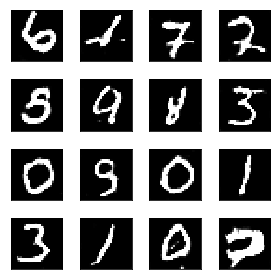

Epochs: 11, Generator Loss: 5.149919509887695, Discriminator Loss: 7.142501354217529
Epochs: 12, Generator Loss: 1.0539681911468506, Discriminator Loss: 4.489360809326172
Epochs: 13, Generator Loss: 3.6234333515167236, Discriminator Loss: 3.306039571762085
Epochs: 14, Generator Loss: 1.4773503541946411, Discriminator Loss: 2.6540141105651855
Epochs: 15, Generator Loss: 5.364692687988281, Discriminator Loss: 7.03726863861084
Epochs: 16, Generator Loss: 7.483453273773193, Discriminator Loss: 7.711269855499268
Epochs: 17, Generator Loss: 9.73849105834961, Discriminator Loss: 10.89560604095459
Epochs: 18, Generator Loss: 4.468361854553223, Discriminator Loss: 3.3922460079193115
Epochs: 19, Generator Loss: 6.214432716369629, Discriminator Loss: 9.042703628540039
Epochs: 20, Generator Loss: 1.861386775970459, Discriminator Loss: 2.0043208599090576


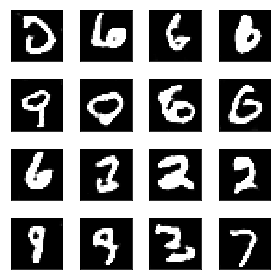

Epochs: 21, Generator Loss: 11.997629165649414, Discriminator Loss: 14.515320777893066
Epochs: 22, Generator Loss: 15.179105758666992, Discriminator Loss: 14.469330787658691
Epochs: 23, Generator Loss: 3.22357439994812, Discriminator Loss: 3.6762397289276123
Epochs: 24, Generator Loss: 10.732688903808594, Discriminator Loss: 11.254782676696777
Epochs: 25, Generator Loss: 4.632294654846191, Discriminator Loss: 4.491166591644287
Epochs: 26, Generator Loss: 5.417490482330322, Discriminator Loss: 5.564373970031738
Epochs: 27, Generator Loss: 0.38779759407043457, Discriminator Loss: 6.354214668273926
Epochs: 28, Generator Loss: 2.3767404556274414, Discriminator Loss: 3.701402187347412
Epochs: 29, Generator Loss: 0.9868786931037903, Discriminator Loss: 3.630657434463501
Epochs: 30, Generator Loss: 1.149243712425232, Discriminator Loss: 2.9058103561401367


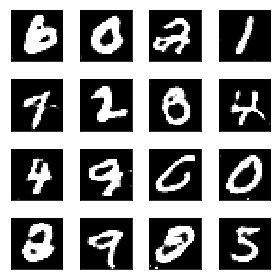

Epochs: 31, Generator Loss: 7.471826553344727, Discriminator Loss: 9.003040313720703
Epochs: 32, Generator Loss: 3.350944757461548, Discriminator Loss: 1.5162924528121948
Epochs: 33, Generator Loss: 12.714761734008789, Discriminator Loss: 11.585759162902832
Epochs: 34, Generator Loss: 13.801307678222656, Discriminator Loss: 15.989068984985352
Epochs: 35, Generator Loss: 16.11809539794922, Discriminator Loss: 16.11809539794922
Epochs: 36, Generator Loss: 5.506438255310059, Discriminator Loss: 5.1671671867370605
Epochs: 37, Generator Loss: 13.506555557250977, Discriminator Loss: 14.560140609741211
Epochs: 38, Generator Loss: 16.11809539794922, Discriminator Loss: 15.803230285644531
Epochs: 39, Generator Loss: 10.689119338989258, Discriminator Loss: 11.408941268920898
Epochs: 40, Generator Loss: 5.55953311920166, Discriminator Loss: 5.087902545928955


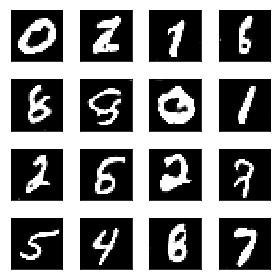

Epochs: 41, Generator Loss: 2.914700984954834, Discriminator Loss: 3.3270742893218994
Epochs: 42, Generator Loss: 2.8642852306365967, Discriminator Loss: 4.026561737060547
Epochs: 43, Generator Loss: 3.9642364978790283, Discriminator Loss: 3.545055627822876
Epochs: 44, Generator Loss: 1.8605692386627197, Discriminator Loss: 1.4600032567977905
Epochs: 45, Generator Loss: 4.5940632820129395, Discriminator Loss: 3.1493752002716064
Epochs: 46, Generator Loss: 5.348519325256348, Discriminator Loss: 5.870650291442871
Epochs: 47, Generator Loss: 6.601743698120117, Discriminator Loss: 9.927148818969727
Epochs: 48, Generator Loss: 11.188216209411621, Discriminator Loss: 10.921563148498535
Epochs: 49, Generator Loss: 13.114837646484375, Discriminator Loss: 14.747736930847168
Epochs: 50, Generator Loss: 4.882702827453613, Discriminator Loss: 3.3182880878448486


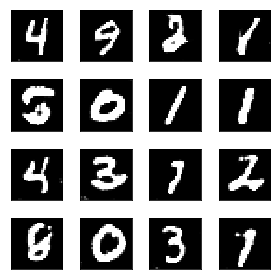

Epochs: 51, Generator Loss: 4.601500511169434, Discriminator Loss: 3.149461269378662
Epochs: 52, Generator Loss: 3.7566208839416504, Discriminator Loss: 2.8452131748199463
Epochs: 53, Generator Loss: 4.680755615234375, Discriminator Loss: 4.215928554534912
Epochs: 54, Generator Loss: 6.55286169052124, Discriminator Loss: 4.891258716583252
Epochs: 55, Generator Loss: 7.875825881958008, Discriminator Loss: 10.059830665588379
Epochs: 56, Generator Loss: 5.507407188415527, Discriminator Loss: 4.688667297363281
Epochs: 57, Generator Loss: 10.94645881652832, Discriminator Loss: 11.766157150268555
Epochs: 58, Generator Loss: 10.332986831665039, Discriminator Loss: 9.945550918579102
Epochs: 59, Generator Loss: 5.3399505615234375, Discriminator Loss: 4.690121173858643
Epochs: 60, Generator Loss: 11.572891235351562, Discriminator Loss: 10.461113929748535


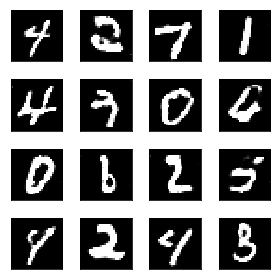

Epochs: 61, Generator Loss: 4.965306758880615, Discriminator Loss: 2.3502039909362793
Epochs: 62, Generator Loss: 2.431377410888672, Discriminator Loss: 2.082148313522339
Epochs: 63, Generator Loss: 3.028376817703247, Discriminator Loss: 1.9766167402267456
Epochs: 64, Generator Loss: 3.1938610076904297, Discriminator Loss: 4.573143005371094
Epochs: 65, Generator Loss: 4.100767135620117, Discriminator Loss: 2.7603952884674072
Epochs: 66, Generator Loss: 4.083806037902832, Discriminator Loss: 3.708463430404663
Epochs: 67, Generator Loss: 8.817176818847656, Discriminator Loss: 8.220229148864746
Epochs: 68, Generator Loss: 3.656137466430664, Discriminator Loss: 2.439880847930908
Epochs: 69, Generator Loss: 4.352197170257568, Discriminator Loss: 4.161677360534668
Epochs: 70, Generator Loss: 2.5384950637817383, Discriminator Loss: 2.949187755584717


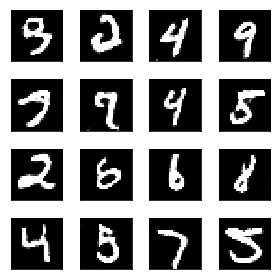

Epochs: 71, Generator Loss: 1.224120020866394, Discriminator Loss: 3.148383140563965
Epochs: 72, Generator Loss: 2.0866222381591797, Discriminator Loss: 3.438868761062622
Epochs: 73, Generator Loss: 4.9754767417907715, Discriminator Loss: 5.056222438812256
Epochs: 74, Generator Loss: 7.233681678771973, Discriminator Loss: 6.182681560516357
Epochs: 75, Generator Loss: 5.662136077880859, Discriminator Loss: 3.9824399948120117
Epochs: 76, Generator Loss: 4.001788139343262, Discriminator Loss: 1.6922459602355957
Epochs: 77, Generator Loss: 8.041709899902344, Discriminator Loss: 8.31071662902832
Epochs: 78, Generator Loss: 4.835218906402588, Discriminator Loss: 2.9653890132904053
Epochs: 79, Generator Loss: 5.562699317932129, Discriminator Loss: 4.87083625793457
Epochs: 80, Generator Loss: 3.075559616088867, Discriminator Loss: 2.230264186859131


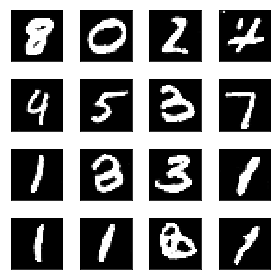

Epochs: 81, Generator Loss: 4.8809309005737305, Discriminator Loss: 4.009298324584961
Epochs: 82, Generator Loss: 3.515873432159424, Discriminator Loss: 3.976290702819824
Epochs: 83, Generator Loss: 7.961029052734375, Discriminator Loss: 8.507019996643066
Epochs: 84, Generator Loss: 9.501609802246094, Discriminator Loss: 8.267851829528809
Epochs: 85, Generator Loss: 10.783226013183594, Discriminator Loss: 14.938812255859375
Epochs: 86, Generator Loss: 15.684064865112305, Discriminator Loss: 15.57524585723877
Epochs: 87, Generator Loss: 8.502164840698242, Discriminator Loss: 9.757651329040527
Epochs: 88, Generator Loss: 10.974603652954102, Discriminator Loss: 11.84459400177002
Epochs: 89, Generator Loss: 16.11809539794922, Discriminator Loss: 16.077682495117188
Epochs: 90, Generator Loss: 12.675389289855957, Discriminator Loss: 12.387840270996094


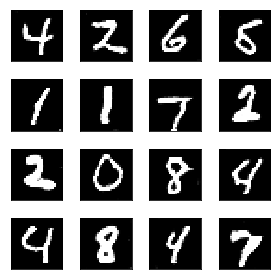

Epochs: 91, Generator Loss: 7.080523490905762, Discriminator Loss: 4.9407548904418945
Epochs: 92, Generator Loss: 4.763972282409668, Discriminator Loss: 4.731651306152344
Epochs: 93, Generator Loss: 3.4946532249450684, Discriminator Loss: 3.157649040222168
Epochs: 94, Generator Loss: 6.230679512023926, Discriminator Loss: 5.117827892303467
Epochs: 95, Generator Loss: 4.357216835021973, Discriminator Loss: 4.066637992858887
Epochs: 96, Generator Loss: 3.4399566650390625, Discriminator Loss: 3.7440245151519775
Epochs: 97, Generator Loss: 6.375820159912109, Discriminator Loss: 6.033401966094971
Epochs: 98, Generator Loss: 5.88279390335083, Discriminator Loss: 5.076385498046875
Epochs: 99, Generator Loss: 11.202237129211426, Discriminator Loss: 13.514137268066406
Epochs: 100, Generator Loss: 11.602825164794922, Discriminator Loss: 11.259032249450684


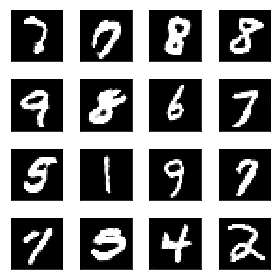

In [18]:
# sample_size, generator_lr, generator_momentum, discriminator_lr, discriminator_momentum, leakyAlpha, epochs, batch_size, eval_size, smooth
train_model(sample_size=100,generator_lr=0.0001, generator_momentum=0.9, discriminator_lr=0.001, discriminator_momentum=0.9, leakyAlpha=0.2, epochs=100, batch_size=128, eval_size=16, smooth=0.1);

So, finally after 100 iterations we see that the DCGAN Model has learnt to generate the MNSIT images using generator and fool the discriminator.